In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!ls /kaggle/input/himawari-satellite-typhoon-dataset/himawari

Installing pyphoon2: (turn internet option on in settings of this notebook for git clone to work)

In [1]:
!ls 

client_secrets.json  model3	      model4_2	pyphoon2       train_loss.npy
model1		     model3_batch128  model5	state.db       val_loss.npy
model2		     model4	      model6	test_loss.npy


In [ ]:
!git clone https://github.com/kitamoto-lab/pyphoon2

In [1]:
!conda install -y mpi4py

Retrieving notices: ...working... done
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.4.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.4.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - mpi4py


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    impi_rt-2021.12.0          |     ha770c72_535        35.7 MB  conda-forge
    mpi-1.0                    |             impi           6 KB  conda-forge
    mpi4py-3.1.6               |  py310h45b48a2_0         528 KB  conda-forge
    openssl-3.3.0              |       hd590300_0         2.8 MB  conda-forge
    ------------------------------------------------------------
                      

In [2]:
!pip install ./pyphoon2

Processing ./pyphoon2
  Preparing metadata (setup.py) ... done
  Created wheel for pyphoon2: filename=pyphoon2-1.0.0-py3-none-any.whl size=25662 sha256=f7949989f091d9307528bf3525f157ee02b83812ff9a0b2f970bcd8113b8a1ee
  Stored in directory: /tmp/pip-ephem-wheel-cache-6xrqxk3p/wheels/d2/ec/5f/a436499ccd3bd3e80debe49cb9c3e33946d67eb85bf2419bbb
Successfully built pyphoon2


In [3]:
!pip install torchsummary

**START FROM HERE IF NOT RUNNING FOR THE FIRST TIME**

In [4]:
import os
data_path = '/kaggle/input/himawari-satellite-typhoon-dataset/himawari (2)/himawari'
images_path = os.path.join(data_path, 'image/')
metadata_path = os.path.join(data_path, 'metadata/')
json_path = '/kaggle/input/himawari-typhoon-metadata/metadata.json'

In [ ]:
# Hyperparameters
num_epochs = 50
batch_size = 64
learning_rate = 0.01
standardize_range = (150, 350)
downsample_size = (224, 224)

In [ ]:
import numpy as np
import torch

# preprocessing function:
def transform_func(image_ray):
    # Clip the pixel values between 150 and 350
    image_ray = np.clip(image_ray, standardize_range[0], standardize_range[1])

    # Standardize the pixel values between 0 and 1
    image_ray = (image_ray - standardize_range[0]) / (standardize_range[1] - standardize_range[0])

    # Downsample the images to 224, 224
    if downsample_size != (512, 512):
        image_ray = torch.Tensor(image_ray)
        image_ray = torch.reshape(image_ray, [1, 1, image_ray.size()[0], image_ray.size()[1]])
        image_ray = torch.nn.functional.interpolate(image_ray, size=downsample_size, mode='bilinear', align_corners=False)
        image_ray = torch.reshape(image_ray, [image_ray.size()[2], image_ray.size()[3]])
        image_ray = image_ray.numpy()
    return image_ray

In [ ]:
from pyphoon2.DigitalTyphoonDataset import DigitalTyphoonDataset

dataset = DigitalTyphoonDataset(
    str(images_path),
    str(metadata_path),
    str(json_path),
    'pressure', # retreive pressure label from the dataset
    transform_func=transform_func,  # the transform function defined above)
)

In [ ]:
print('No of sequences:', dataset.get_number_of_sequences())

In [ ]:
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Creating a random number generator with a seed value, then generating train test split

In [ ]:
import torch

seed = 42
generator = torch.Generator().manual_seed(seed)
train_set, val_set, test_set = dataset.random_split([0.7, 0.1, 0.2], split_by='image', generator=generator)

In [ ]:
print('No of images in train set:', len(train_set))
print('No of images in validation set:', len(val_set))
print('No of images in test set:', len(test_set))

In [ ]:
from torch.utils.data import DataLoader

trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
print('No of train batches:', len(trainloader))

Creating the model:

In [ ]:
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

# Load a ResNet model
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Freeze pre-trained layers as the dataset is small
for param in model.parameters():
    param.requires_grad = False  # Freeze all parameters

# Modify the model to take single channel images
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=True)

# Modify the model for regressing the wind pressure
num_features_in = model.fc.in_features  # Get the number of input features from the previous layer
model.fc = nn.Linear(in_features=num_features_in, out_features=1)  # New linear layer with 1 output

# Unfreeze first layer and last layer
for param in model.conv1.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

In [ ]:
print(model)

In [ ]:
from torchsummary import summary
model = model.to(device)
summary(model, (1, 224, 224))

In [ ]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Training and validation functions:

In [ ]:
def train(model, trainloader):
    running_loss = 0.0
    total_loss = 0.0
    
    model.train()
    
    for batch_num, data in enumerate(trainloader):
        # One batch of the data (64 images and 64 labels) are held in the data variable

        # Data is a tuple, with images in data[0] and labels in data[1]
        images, labels = data

        
        # Move data to device (GPU/CPU)
        images, labels = images.to(device), labels.to(device)  
        
        # cast pixels and labels to float
        images, labels = torch.Tensor(images).float(), torch.Tensor(labels).float()

        # Reshape the image tensor to add a channel dimension (only one channel)
        images = torch.reshape(images, [images.size()[0], 1, images.size()[1], images.size()[2]])
        
        optimizer.zero_grad()

        # Forward pass
        predictions = model(images)
        # Calculate the loss
        predictions = torch.reshape(predictions, labels.shape)
        loss = criterion(predictions, labels)
        # backward pass
        loss.backward()
        # update weights
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        total_loss += loss.item() 
        if batch_num % 50 == 49:    # print every 50 mini-batches
            print(f'From batch {batch_num - 49} to batch {batch_num} | RMSE: {(running_loss / 50) ** 0.5:.3f}')
            running_loss = 0.0
     
    total_loss /= len(trainloader)
    return total_loss

In [ ]:
def validate(model, valloader):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation during validation
        for data, target in valloader:
            data, target = data.to(device), target.to(device)  # Move data to device (GPU/CPU)
            data = torch.reshape(data, [data.size()[0], 1, data.size()[1], data.size()[2]])
            output = model(data)
            output = torch.reshape(output, target.shape)
            loss = criterion(output, target)
            total_loss += loss.item()
        return total_loss / len(valloader)

Training loop:

In [ ]:
from datetime import datetime

max_epochs = num_epochs
print(f'Running for {num_epochs} epochs')

train_losses = []
val_losses = []

best_vloss = 1_000_000.

model_dir = 'model1'
os.makedirs(model_dir, exist_ok=True)

# use GPU
model = model.to(device)

for epoch in tqdm(range(max_epochs)):
    print('EPOCH {}:'.format(epoch + 1))
    
    train_loss = train(model, trainloader)
    print(f'\nTraining loss of epoch {epoch + 1}: {train_loss ** 0.5:.3f}')
    train_losses.append(train_loss)
    
    val_loss = validate(model, valloader)
    print(f'\Validation loss of epoch {epoch + 1}: {val_loss ** 0.5:.3f}')
    val_losses.append(val_loss)
    
    if val_loss < best_vloss: # Save the model
        best_vloss = val_loss
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        model_path = os.path.join(model_dir, 'model_{}_{}'.format(timestamp, epoch))
        print(f'Model with current best validation loss saved! Path: {model_path}')
        torch.save(model.state_dict(), model_path)

In [ ]:
import numpy as np
train_losses_np = np.array(train_losses)
val_losses_np = np.array(val_losses)
np.save('train_loss.npy', train_losses_np)
np.save('val_loss.npy', val_losses_np)

Testing:

In [ ]:
def create_and_load_model(path_to_state_dict):
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=True)
    num_features_in = model.fc.in_features  
    model.fc = nn.Linear(in_features=num_features_in, out_features=1)  
    model.load_state_dict(torch.load(path_to_state_dict))
    return model

In [ ]:
model_dir  = '/kaggle/working/model1'
test_losses = {}
for model_name in os.listdir(model_dir):
    if model_name[-2] == '_':
        continue
    epoch_num = int(model_name[-2:])
    model_path = os.path.join(model_dir, model_name)
    model = create_and_load_model(model_path)
    model = model.to(device)
    test_losses[epoch_num] = validate(model, testloader)
    print(f'Test RMSE of epoch {epoch_num + 1}: {test_losses[epoch_num] ** 0.5:.3f}')

In [ ]:
import numpy as np
max_val = -1
test_losses_np = np.ones(num_epochs) * max_val
for (k, v) in test_losses.items():
    test_losses_np[k] = v
np.save('test_loss.npy', test_losses_np)

Basic CNN: Model 2

In [ ]:
import numpy as np
import torch
import torchvision.transforms.v2.functional as transforms
from torch.utils.data import DataLoader
from pyphoon2.DigitalTyphoonDataset import DigitalTyphoonDataset


# Hyperparameters
num_epochs = 50
batch_size = 64
learning_rate = 0.01
standardize_range = (150, 350)
downsample_size = (512, 512)

# preprocessing function:
def transform_func(image_ray):
    # Clip the pixel values between 150 and 350
    image_ray = np.clip(image_ray, standardize_range[0], standardize_range[1])

    image_ray = torch.Tensor(image_ray)
    image_ray = torch.reshape(image_ray, [1, 1, image_ray.size()[0], image_ray.size()[1]])

    # Apply z-score normalization
    image_ray = transforms.normalize(image_ray, [image_ray.mean()], [image_ray.std()])

    # Downsample the images 
    if downsample_size != (512, 512):
        image_ray = transforms.resize(image_ray, size=downsample_size)

    # augmentation

    # random horizontal flip
    image_ray = transforms.horizontal_flip(image_ray)
    # random vertical flip
    image_ray = transforms.vertical_flip(image_ray)
    # random rotation flip
    image_ray = transforms.rotate(image_ray, angle=10)

    image_ray = torch.reshape(image_ray, [image_ray.size()[2], image_ray.size()[3]])
    return image_ray.numpy()



dataset = DigitalTyphoonDataset(
    str(images_path),
    str(metadata_path),
    str(json_path),
    'pressure', # retreive pressure label from the dataset
    transform_func=transform_func,  # the transform function defined above)
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


seed = 42
generator = torch.Generator().manual_seed(seed)
train_set, val_set, test_set = dataset.random_split([0.7, 0.1, 0.2], split_by='image', generator=generator)

trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
import torch
from torch import nn

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    # Convolutional layers
    self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2)  # Input 1 channel, 16 filters, kernel 4x4, stride 2
#     self.pool1 = nn.MaxPool2d(2, 2)  # Max pooling after conv1
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2)  # 16 input channels, 32 filters, kernel 3x3, stride 2
    self.pool2 = nn.MaxPool2d(2, 2)  # Max pooling after conv2
    self.relu2 = nn.ReLU()
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2)  # 32 input channels, 64 filters, kernel 3x3, stride 2
    self.pool3 = nn.MaxPool2d(2, 2)  # Max pooling after conv3
    self.relu3 = nn.ReLU()
    self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2)  # 64 input channels, 128 filters, kernel 3x3, stride 2
    self.pool4 = nn.MaxPool2d(2, 2)  # Max pooling after conv4
    self.relu4 = nn.ReLU()

    # Fully connected layers
    self.fc1 = nn.Linear(2304, 64)  # Flatten output of conv4, 256 neurons
    self.relu5 = nn.ReLU()
    self.fc2 = nn.Linear(64, 32)  # 256 input neurons, 128 neurons
    self.relu6 = nn.ReLU()
    self.fc3 = nn.Linear(32, 1)  # 128 input neurons, 1 output neuron

  def forward(self, x):
    x = self.relu1(self.conv1(x))
    x = self.relu2(self.pool2(self.conv2(x)))
    x = self.relu3(self.pool3(self.conv3(x)))
    x = self.relu4(self.pool4(self.conv4(x)))
    x = torch.flatten(x, 1)
    x = self.relu5(self.fc1(x))
    x = self.relu6(self.fc2(x))
    x = self.fc3(x)
    return x

# Example usage
model = CNN()

In [ ]:
from torchsummary import summary
model = model.to(device)
summary(model, (1, 512, 512))

In [ ]:
from datetime import datetime
from tqdm import tqdm

max_epochs = num_epochs
print(f'Running for {num_epochs} epochs')

train_losses = []
val_losses = []

best_vloss = 1_000_000.

model_dir = 'model2'
os.makedirs(model_dir, exist_ok=True)

# use GPU
model = model.to(device)

for epoch in tqdm(range(max_epochs)):
    print('EPOCH {}:'.format(epoch + 1))
    
    train_loss = train(model, trainloader)
    print(f'\nTraining loss of epoch {epoch + 1}: {train_loss ** 0.5:.3f}')
    train_losses.append(train_loss)
    
    val_loss = validate(model, valloader)
    print(f'\Validation loss of epoch {epoch + 1}: {val_loss ** 0.5:.3f}')
    val_losses.append(val_loss)
    
    if val_loss < best_vloss: # Save the model
        best_vloss = val_loss
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        model_path = os.path.join(model_dir, 'model_{}_{}'.format(timestamp, epoch))
        print(f'Model with current best validation loss saved! Path: {model_path}')
        torch.save(model.state_dict(), model_path)

In [ ]:
import numpy as np
train_losses_np = np.array(train_losses)
val_losses_np = np.array(val_losses)
model_dir = 'model2'
np.save(os.path.join(model_dir, 'train_loss.npy'), train_losses_np)
np.save(os.path.join(model_dir, 'val_loss.npy'), val_losses_np)

Testing:

In [ ]:
def create_and_load_model(path_to_state_dict):
    model = CNN()
    model.load_state_dict(torch.load(path_to_state_dict))
    return model

model_dir  = '/kaggle/working/model2'
test_losses = {}
for model_name in os.listdir(model_dir):
    if model_name.endswith('npy'):
    epoch_num = int(model_name[-1])
    model_path = os.path.join(model_dir, model_name)
    model = create_and_load_model(model_path)
    model = model.to(device)
    test_losses[epoch_num] = validate(model, testloader)
    print(f'Test RMSE of epoch {epoch_num + 1}: {test_losses[epoch_num] ** 0.5:.3f}')

In [ ]:
import numpy as np
max_val = -1
test_losses_np = np.ones(num_epochs) * max_val
for (k, v) in test_losses.items():
    test_losses_np[k] = v
np.save(os.path.join(model_dir, 'test_loss.npy'), test_losses_np)

Basic CNN with a modified architecture: model 3

In [ ]:
import numpy as np
import torch
import torchvision.transforms.v2.functional as transforms
from torch.utils.data import DataLoader
from pyphoon2.DigitalTyphoonDataset import DigitalTyphoonDataset


# Hyperparameters
num_epochs = 50
batch_size = 128
learning_rate = 0.01
standardize_range = (150, 350)
downsample_size = (256, 256)

# preprocessing function:
def transform_func(image_ray):
    # Clip the pixel values between 150 and 350
    image_ray = np.clip(image_ray, standardize_range[0], standardize_range[1])

    image_ray = torch.Tensor(image_ray)
    image_ray = torch.reshape(image_ray, [1, 1, image_ray.size()[0], image_ray.size()[1]])

    # Apply z-score normalization
    image_ray = transforms.normalize(image_ray, [image_ray.mean()], [image_ray.std()])

    # Downsample the images 
    if downsample_size != (512, 512):
        image_ray = transforms.resize(image_ray, size=downsample_size, antialias=True)

    # augmentation

    # random horizontal flip
    image_ray = transforms.horizontal_flip(image_ray)
    # random vertical flip
    image_ray = transforms.vertical_flip(image_ray)
    # random rotation flip
    image_ray = transforms.rotate(image_ray, angle=10)

    image_ray = torch.reshape(image_ray, [image_ray.size()[2], image_ray.size()[3]])
    return image_ray.numpy()



dataset = DigitalTyphoonDataset(
    str(images_path),
    str(metadata_path),
    str(json_path),
    'pressure', # retreive pressure label from the dataset
    transform_func=transform_func,  # the transform function defined above)
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


seed = 42
generator = torch.Generator().manual_seed(seed)
train_set, val_set, test_set = dataset.random_split([0.7, 0.1, 0.2], split_by='image', generator=generator)

trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
import torch
from torch import nn

class CNN2(nn.Module):
  def __init__(self):
    super(CNN2, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2)  
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=2) 
    self.relu2 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2, 2) 
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
    self.relu3 = nn.ReLU()
    self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=2)
    self.relu4 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(2, 2) 

    self.fc1 = nn.Linear(576, 128)  
    self.relu5 = nn.ReLU()
    self.dropout = nn.Dropout(p=0.3)
    self.fc2 = nn.Linear(128, 1)

  def forward(self, x):
    x = self.relu1(self.conv1(x))
    x = self.relu2(self.conv2(x))
    x = self.pool1(x)
    x = self.relu3(self.conv3(x))
    x = self.relu4(self.conv4(x))
    x = self.pool2(x)
    x = torch.flatten(x, 1)
    x = self.relu5(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

model = CNN2()

In [ ]:
# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Run train and validate function cells after this

In [ ]:
from torchsummary import summary
model = model.to(device)
summary(model, (1, 256, 256))

In [ ]:
from datetime import datetime
from tqdm import tqdm

max_epochs = num_epochs
print(f'Running for {num_epochs} epochs')

train_losses = []
val_losses = []

best_vloss = 1_000_000.

model_dir = 'model3_batch128'
os.makedirs(model_dir, exist_ok=True)

# use GPU
model = model.to(device)

for epoch in tqdm(range(max_epochs)):
    print('EPOCH {}:'.format(epoch + 1))
    
    train_loss = train(model, trainloader)
    print(f'\nTraining loss of epoch {epoch + 1}: {train_loss ** 0.5:.3f}')
    train_losses.append(train_loss)
    
    val_loss = validate(model, valloader)
    print(f'\Validation RMSE of epoch {epoch + 1}: {val_loss ** 0.5:.3f}')
    val_losses.append(val_loss)
    
    if val_loss < best_vloss: # Save the model
        best_vloss = val_loss
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        model_path = os.path.join(model_dir, 'model_{}_{}'.format(timestamp, epoch))
        print(f'Model with current best validation loss saved! Path: {model_path}')
        torch.save(model.state_dict(), model_path)

In [ ]:
import numpy as np
train_losses_np = np.array(train_losses)
val_losses_np = np.array(val_losses)
model_dir = 'model3_batch128'
np.save(os.path.join(model_dir, 'train_loss.npy'), train_losses_np)
np.save(os.path.join(model_dir, 'val_loss.npy'), val_losses_np)

In [ ]:
def create_and_load_model(path_to_state_dict):
    model = CNN2()
    model.load_state_dict(torch.load(path_to_state_dict))
    return model

model_dir  = '/kaggle/working/model3_batch128'
test_losses = {}
for model_name in os.listdir(model_dir):
    if model_name.endswith('npy'):
        continue
    epoch_num = int(model_name[-1])
    model_path = os.path.join(model_dir, model_name)
    model = create_and_load_model(model_path)
    model = model.to(device)
    test_losses[epoch_num] = validate(model, testloader)
    print(f'Test RMSE of epoch {epoch_num + 1}: {test_losses[epoch_num] ** 0.5:.3f}')

import numpy as np
max_val = -1
test_losses_np = np.ones(num_epochs) * max_val
for (k, v) in test_losses.items():
    test_losses_np[k] = v
np.save(os.path.join(model_dir, 'test_loss.npy'), test_losses_np)

Model 4 - resnet 34

In [6]:
import numpy as np
import torch
import torchvision.transforms.v2.functional as transforms
from torch.utils.data import DataLoader
from pyphoon2.DigitalTyphoonDataset import DigitalTyphoonDataset


# Hyperparameters
num_epochs = 50
batch_size = 128
learning_rate = 0.01
standardize_range = (150, 350)
downsample_size = (224, 224)

# preprocessing function:
def transform_func(image_ray):
    # Clip the pixel values between 150 and 350
    image_ray = np.clip(image_ray, standardize_range[0], standardize_range[1])

    image_ray = torch.Tensor(image_ray)
    image_ray = torch.reshape(image_ray, [1, 1, image_ray.size()[0], image_ray.size()[1]])

    # Apply z-score normalization
    image_ray = transforms.normalize(image_ray, [image_ray.mean()], [image_ray.std()])

    # Downsample the images 
    if downsample_size != (512, 512):
        image_ray = transforms.resize(image_ray, size=downsample_size, antialias=True)

    # augmentation

    # random horizontal flip
    image_ray = transforms.horizontal_flip(image_ray)
    # random vertical flip
    image_ray = transforms.vertical_flip(image_ray)
    # random rotation flip
    image_ray = transforms.rotate(image_ray, angle=10)

    image_ray = torch.reshape(image_ray, [image_ray.size()[2], image_ray.size()[3]])
    return image_ray.numpy()



dataset = DigitalTyphoonDataset(
    str(images_path),
    str(metadata_path),
    str(json_path),
    'pressure', # retreive pressure label from the dataset
    transform_func=transform_func,  # the transform function defined above)
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


seed = 42
generator = torch.Generator().manual_seed(seed)
train_set, val_set, test_set = dataset.random_split([0.7, 0.1, 0.2], split_by='image', generator=generator)

trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print('Number of training batches:', len(trainloader))

Number of training batches: 184


In [ ]:
import torch.nn as nn
from torchvision.models import resnet34, ResNet34_Weights

# Load a ResNet model
model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

# Freeze pre-trained layers as the dataset is small
for param in model.parameters():
    param.requires_grad = False  # Freeze all parameters

# Modify the model to take single channel images
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=True)

# Modify the model for regressing the wind pressure
num_features_in = model.fc.in_features  # Get the number of input features from the previous layer
model.fc = nn.Linear(in_features=num_features_in, out_features=1)  # New linear layer with 1 output

# Unfreeze first layer and last layer
for param in model.conv1.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

In [ ]:
from torchsummary import summary
model = model.to(device)
summary(model, (1, 224, 224))

In [ ]:
print(model)

In [ ]:
# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from datetime import datetime
from tqdm import tqdm

max_epochs = 15
print(f'Running for {max_epochs} epochs')

train_losses = []
val_losses = []

best_vloss = 1_000_000.

model_dir = 'model4_2'
os.makedirs(model_dir, exist_ok=True)

# use GPU
model = model.to(device)

for epoch in tqdm(range(max_epochs)):
    print('EPOCH {}:'.format(epoch + 1))
    
    train_loss = train(model, trainloader)
    print(f'\nTraining RMSE of epoch {epoch + 1}: {train_loss ** 0.5:.3f}')
    train_losses.append(train_loss)
    
    val_loss = validate(model, valloader)
    print(f'\Validation RMSE of epoch {epoch + 1}: {val_loss ** 0.5:.3f}')
    val_losses.append(val_loss)
    
    if val_loss < best_vloss: # Save the model
        best_vloss = val_loss
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        model_path = os.path.join(model_dir, 'model_{}_{}'.format(timestamp, epoch))
        print(f'Model with current best validation loss saved! Path: {model_path}')
        torch.save(model.state_dict(), model_path)

In [ ]:
import numpy as np
train_losses_np = np.array(train_losses)
val_losses_np = np.array(val_losses)
model_dir = 'model4_2'
np.save(os.path.join(model_dir, 'train_loss.npy'), train_losses_np)
np.save(os.path.join(model_dir, 'val_loss.npy'), val_losses_np)

In [ ]:
def create_and_load_model(path_to_state_dict):
    model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=True)
    num_features_in = model.fc.in_features
    model.fc = nn.Linear(in_features=num_features_in, out_features=1)  
    model.load_state_dict(torch.load(path_to_state_dict))
    return model

model_dir  = '/kaggle/working/model4_2'
test_losses = {}
for model_name in os.listdir(model_dir):
    if model_name.endswith('npy'):
        continue
    epoch_num = int(model_name[-1])
    model_path = os.path.join(model_dir, model_name)
    model = create_and_load_model(model_path)
    model = model.to(device)
    test_losses[epoch_num] = validate(model, testloader)
    print(f'Test RMSE of epoch {epoch_num + 1}: {test_losses[epoch_num] ** 0.5:.3f}')

import numpy as np
max_val = -1
test_losses_np = np.ones(num_epochs) * max_val
for (k, v) in test_losses.items():
    test_losses_np[k] = v
np.save(os.path.join(model_dir, 'test_loss.npy'), test_losses_np)

Model 5: Resnet 50

In [ ]:
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

# Load a ResNet model
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Freeze pre-trained layers as the dataset is small
for param in model.parameters():
    param.requires_grad = False  # Freeze all parameters

# Modify the model to take single channel images
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=True)

# Modify the model for regressing the wind pressure
num_features_in = model.fc.in_features  # Get the number of input features from the previous layer
model.fc = nn.Linear(in_features=num_features_in, out_features=1)  # New linear layer with 1 output

# Unfreeze first layer and last layer
for param in model.conv1.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

In [ ]:
from torchsummary import summary
model = model.to(device)
summary(model, (1, 224, 224))

In [ ]:
print(model)

In [ ]:
# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train(model, trainloader):
    running_loss = 0.0
    total_loss = 0.0
    
    model.train()
    
    for batch_num, data in enumerate(trainloader):
        # One batch of the data (64 images and 64 labels) are held in the data variable

        # Data is a tuple, with images in data[0] and labels in data[1]
        images, labels = data

        
        # Move data to device (GPU/CPU)
        images, labels = images.to(device), labels.to(device)  
        
        # cast pixels and labels to float
        images, labels = torch.Tensor(images).float(), torch.Tensor(labels).float()

        # Reshape the image tensor to add a channel dimension (only one channel)
        images = torch.reshape(images, [images.size()[0], 1, images.size()[1], images.size()[2]])
        
        optimizer.zero_grad()

        # Forward pass
        predictions = model(images)
        # Calculate the loss
        predictions = torch.reshape(predictions, labels.shape)
        loss = criterion(predictions, labels)
        # backward pass
        loss.backward()
        # update weights
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        total_loss += loss.item() 
        if batch_num % 50 == 49:    # print every 50 mini-batches
            print(f'From batch {batch_num - 49} to batch {batch_num} | RMSE: {(running_loss / 50) ** 0.5:.3f}')
            running_loss = 0.0
     
    total_loss /= len(trainloader)
    return total_loss

def validate(model, valloader):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation during validation
        for data, target in valloader:
            data, target = data.to(device), target.to(device)  # Move data to device (GPU/CPU)
            data = torch.reshape(data, [data.size()[0], 1, data.size()[1], data.size()[2]])
            output = model(data)
            output = torch.reshape(output, target.shape)
            loss = criterion(output, target)
            total_loss += loss.item()
        return total_loss / len(valloader)

In [ ]:
from datetime import datetime
from tqdm import tqdm

max_epochs = 10
print(f'Running for {max_epochs} epochs')

train_losses = []
val_losses = []

best_vloss = 1_000_000.

model_dir = 'model5'
os.makedirs(model_dir, exist_ok=True)

# use GPU
model = model.to(device)

for epoch in tqdm(range(max_epochs)):
    print('EPOCH {}:'.format(epoch + 1))
    
    train_loss = train(model, trainloader)
    print(f'\nTraining RMSE of epoch {epoch + 1}: {train_loss ** 0.5:.3f}')
    train_losses.append(train_loss)
    
    val_loss = validate(model, valloader)
    print(f'\Validation RMSE of epoch {epoch + 1}: {val_loss ** 0.5:.3f}')
    val_losses.append(val_loss)
    
    if val_loss < best_vloss: # Save the model
        best_vloss = val_loss
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        model_path = os.path.join(model_dir, 'model_{}_{}'.format(timestamp, epoch))
        print(f'Model with current best validation loss saved! Path: {model_path}')
        torch.save(model.state_dict(), model_path)

In [ ]:
import numpy as np
train_losses_np = np.array(train_losses)
val_losses_np = np.array(val_losses)
model_dir = 'model5'
np.save(os.path.join(model_dir, 'train_loss.npy'), train_losses_np)
np.save(os.path.join(model_dir, 'val_loss.npy'), val_losses_np)

In [ ]:
def create_and_load_model(path_to_state_dict):
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=True)
    num_features_in = model.fc.in_features
    model.fc = nn.Linear(in_features=num_features_in, out_features=1)  
    model.load_state_dict(torch.load(path_to_state_dict))
    return model

model_dir  = '/kaggle/working/model5'
test_losses = {}
for model_name in os.listdir(model_dir):
    if model_name.endswith('npy'):
        continue
    epoch_num = int(model_name[-1])
    model_path = os.path.join(model_dir, model_name)
    model = create_and_load_model(model_path)
    model = model.to(device)
    test_losses[epoch_num] = validate(model, testloader)
    print(f'Test RMSE of epoch {epoch_num + 1}: {test_losses[epoch_num] ** 0.5:.3f}')

import numpy as np
max_val = -1
test_losses_np = np.ones(num_epochs) * max_val
for (k, v) in test_losses.items():
    test_losses_np[k] = v
np.save(os.path.join(model_dir, 'test_loss.npy'), test_losses_np)

Model 6: Resnet 18

In [7]:
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

# Load a ResNet model
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Freeze pre-trained layers as the dataset is small
for param in model.parameters():
    param.requires_grad = False  # Freeze all parameters

# Modify the model to take single channel images
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=True)

# Modify the model for regressing the wind pressure
num_features_in = model.fc.in_features  # Get the number of input features from the previous layer
model.fc = nn.Linear(in_features=num_features_in, out_features=1)  # New linear layer with 1 output

# Unfreeze first layer and last layer
for param in model.conv1.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s] 


In [8]:
from torchsummary import summary
model = model.to(device)
summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,200
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [9]:
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2):

In [ ]:
# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train(model, trainloader):
    running_loss = 0.0
    total_loss = 0.0
    
    model.train()
    
    for batch_num, data in enumerate(trainloader):
        # One batch of the data (64 images and 64 labels) are held in the data variable

        # Data is a tuple, with images in data[0] and labels in data[1]
        images, labels = data

        
        # Move data to device (GPU/CPU)
        images, labels = images.to(device), labels.to(device)  
        
        # cast pixels and labels to float
        images, labels = torch.Tensor(images).float(), torch.Tensor(labels).float()

        # Reshape the image tensor to add a channel dimension (only one channel)
        images = torch.reshape(images, [images.size()[0], 1, images.size()[1], images.size()[2]])
        
        optimizer.zero_grad()

        # Forward pass
        predictions = model(images)
        # Calculate the loss
        predictions = torch.reshape(predictions, labels.shape)
        loss = criterion(predictions, labels)
        # backward pass
        loss.backward()
        # update weights
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        total_loss += loss.item() 
        if batch_num % 50 == 49:    # print every 50 mini-batches
            print(f'From batch {batch_num - 49} to batch {batch_num} | RMSE: {(running_loss / 50) ** 0.5:.3f}')
            running_loss = 0.0
     
    total_loss /= len(trainloader)
    return total_loss

def validate(model, valloader):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation during validation
        for data, target in valloader:
            data, target = data.to(device), target.to(device)  # Move data to device (GPU/CPU)
            data = torch.reshape(data, [data.size()[0], 1, data.size()[1], data.size()[2]])
            output = model(data)
            output = torch.reshape(output, target.shape)
            loss = criterion(output, target)
            total_loss += loss.item()
        return total_loss / len(valloader)

In [ ]:
from datetime import datetime
from tqdm import tqdm

max_epochs = 15
print(f'Running for {max_epochs} epochs')

train_losses = []
val_losses = []

best_vloss = 1_000_000.

model_dir = 'model6'
os.makedirs(model_dir, exist_ok=True)

# use GPU
model = model.to(device)

for epoch in tqdm(range(max_epochs)):
    print('EPOCH {}:'.format(epoch + 1))
    
    train_loss = train(model, trainloader)
    print(f'\nTraining RMSE of epoch {epoch + 1}: {train_loss ** 0.5:.3f}')
    train_losses.append(train_loss)
    
    val_loss = validate(model, valloader)
    print(f'\Validation RMSE of epoch {epoch + 1}: {val_loss ** 0.5:.3f}')
    val_losses.append(val_loss)
    
    if val_loss < best_vloss: # Save the model
        best_vloss = val_loss
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        model_path = os.path.join(model_dir, 'model_{}_{}'.format(timestamp, epoch))
        print(f'Model with current best validation loss saved! Path: {model_path}')
        torch.save(model.state_dict(), model_path)

In [ ]:
 import numpy as np
train_losses_np = np.array(train_losses)
val_losses_np = np.array(val_losses)
model_dir = 'model6'
np.save(os.path.join(model_dir, 'train_loss.npy'), train_losses_np)
np.save(os.path.join(model_dir, 'val_loss.npy'), val_losses_np)1

In [ ]:
def create_and_load_model(path_to_state_dict):
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=True)
    num_features_in = model.fc.in_features
    model.fc = nn.Linear(in_features=num_features_in, out_features=1)  
    model.load_state_dict(torch.load(path_to_state_dict))
    return model

model_dir  = '/kaggle/working/model6'
test_losses = {}
for model_name in os.listdir(model_dir):
    if model_name.endswith('npy'):
        continue
    epoch_num = int(model_name[-1])
    model_path = os.path.join(model_dir, model_name)
    model = create_and_load_model(model_path)
    model = model.to(device)
    test_losses[epoch_num] = validate(model, testloader)
    print(f'Test RMSE of epoch {epoch_num + 1}: {test_losses[epoch_num] ** 0.5:.3f}')

import numpy as np
max_val = -1
test_losses_np = np.ones(num_epochs) * max_val
for (k, v) in test_losses.items():
    test_losses_np[k] = v
np.save(os.path.join(model_dir, 'test_loss.npy'), test_losses_np)

Restarting training of model 5 from epoch 11:

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

# Load a ResNet model
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Modify the model to take single channel images
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=True)

# Modify the model for regressing the wind pressure
num_features_in = model.fc.in_features  # Get the number of input features from the previous layer
model.fc = nn.Linear(in_features=num_features_in, out_features=1)  # New linear layer with 1 output

# load the model trained for 10 epochs:
model.load_state_dict(torch.load('/kaggle/working/model5/model_20240426_002246_9'))

# Freeze pre-trained layers as the dataset is small
for param in model.parameters():
    param.requires_grad = False  # Freeze all parameters

# Unfreeze first layer and last layer
for param in model.conv1.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

In [ ]:
# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train(model, trainloader):
    running_loss = 0.0
    total_loss = 0.0
    
    model.train()
    
    for batch_num, data in enumerate(trainloader):
        # One batch of the data (64 images and 64 labels) are held in the data variable

        # Data is a tuple, with images in data[0] and labels in data[1]
        images, labels = data

        
        # Move data to device (GPU/CPU)
        images, labels = images.to(device), labels.to(device)  
        
        # cast pixels and labels to float
        images, labels = torch.Tensor(images).float(), torch.Tensor(labels).float()

        # Reshape the image tensor to add a channel dimension (only one channel)
        images = torch.reshape(images, [images.size()[0], 1, images.size()[1], images.size()[2]])
        
        optimizer.zero_grad()

        # Forward pass
        predictions = model(images)
        # Calculate the loss
        predictions = torch.reshape(predictions, labels.shape)
        loss = criterion(predictions, labels)
        # backward pass
        loss.backward()
        # update weights
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        total_loss += loss.item() 
        if batch_num % 50 == 49:    # print every 50 mini-batches
            print(f'From batch {batch_num - 49} to batch {batch_num} | RMSE: {(running_loss / 50) ** 0.5:.3f}')
            running_loss = 0.0
     
    total_loss /= len(trainloader)
    return total_loss

def validate(model, valloader):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation during validation
        for data, target in valloader:
            data, target = data.to(device), target.to(device)  # Move data to device (GPU/CPU)
            data = torch.reshape(data, [data.size()[0], 1, data.size()[1], data.size()[2]])
            output = model(data)
            output = torch.reshape(output, target.shape)
            loss = criterion(output, target)
            total_loss += loss.item()
        return total_loss / len(valloader)

In [ ]:
from datetime import datetime
from tqdm import tqdm

# max_epochs = 10
print(f'Running for {5} epochs')

train_losses = np.load('/kaggle/input/model-5-loss-history/train_loss.npy').tolist()
val_losses = np.load('/kaggle/input/model-5-loss-history/val_loss.npy').tolist()

best_vloss = 1_000_000.

model_dir = 'model5'
os.makedirs(model_dir, exist_ok=True)

# use GPU
model = model.to(device)

for epoch in tqdm(range(10, 15)):
    print('EPOCH {}:'.format(epoch + 1))
    
    train_loss = train(model, trainloader)
    print(f'\nTraining RMSE of epoch {epoch + 1}: {train_loss ** 0.5:.3f}')
    train_losses.append(train_loss)
    
    val_loss = validate(model, valloader)
    print(f'\Validation RMSE of epoch {epoch + 1}: {val_loss ** 0.5:.3f}')
    val_losses.append(val_loss)
    
    if val_loss < best_vloss: # Save the model
        best_vloss = val_loss
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        model_path = os.path.join(model_dir, 'model_{}_{}'.format(timestamp, epoch))
        print(f'Model with current best validation loss saved! Path: {model_path}')
        torch.save(model.state_dict(), model_path)

In [ ]:
import numpy as np
train_losses_np = np.array(train_losses)
val_losses_np = np.array(val_losses)
model_dir = 'model5'
np.save(os.path.join(model_dir, 'train_loss.npy'), train_losses_np)
np.save(os.path.join(model_dir, 'val_loss.npy'), val_losses_np)

In [ ]:
def create_and_load_model(path_to_state_dict):
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=True)
    num_features_in = model.fc.in_features
    model.fc = nn.Linear(in_features=num_features_in, out_features=1)  
    model.load_state_dict(torch.load(path_to_state_dict))
    return model

model_dir  = '/kaggle/working/model5'
test_losses = {}
for model_name in os.listdir(model_dir):
    if model_name.endswith('npy') or model_name[-2] == '_':
        continue
    epoch_num = int(model_name[-2:])
    model_path = os.path.join(model_dir, model_name)
    model = create_and_load_model(model_path)
    model = model.to(device)
    test_losses[epoch_num] = validate(model, testloader)
    print(f'Test RMSE of epoch {epoch_num + 1}: {test_losses[epoch_num] ** 0.5:.3f}')

import numpy as np
max_val = -1
test_losses_np = np.load('/kaggle/working/model5/test_loss.npy')
for (k, v) in test_losses.items():
    test_losses_np[k] = v
np.save(os.path.join(model_dir, 'test_loss.npy'), test_losses_np)

Running inference on best performing model 6:

In [37]:
# load the trained model:
model.load_state_dict(torch.load('/kaggle/working/model6/model_20240426_032149_14'))

<All keys matched successfully>

Correct central pressure: 994.0
Predicted central presssure: 994.2625122070312
RMSE: 0.26251219993578884


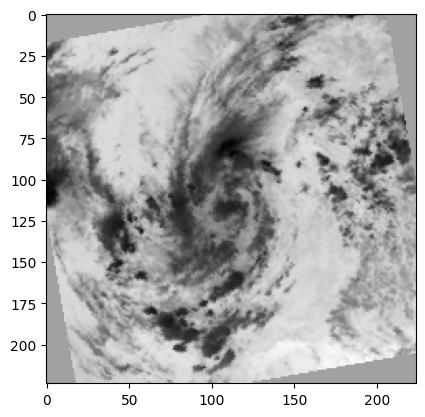

In [45]:
import matplotlib.pyplot as plt

# Loss and optimizer
criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation during validation
    (data, target) = test_set[1000]
    # plot the image
    plt.imshow(data, cmap='gray')
    data = torch.Tensor(data)
    data = data.to(device)
    data = torch.reshape(data, [1, 1, data.size()[0], data.size()[1]])
    output = model(data)
    target = torch.Tensor([target], ).to(device)
    output = torch.reshape(output, (1, ))
    loss = criterion(output, target)
    print(f'Correct central pressure: {target[0]}')
    print(f'Predicted central presssure: {output[0]}')
    print(f'RMSE: {loss.item() ** 0.5}')

Correct central pressure: 976.7000122070312
Predicted central presssure: 979.734130859375
RMSE: 3.03411871066424


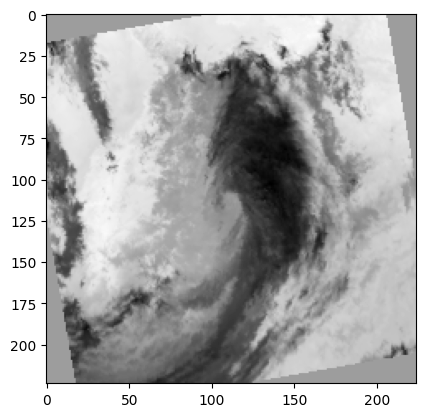

In [46]:
import matplotlib.pyplot as plt

# Loss and optimizer
criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation during validation
    (data, target) = test_set[2000]
    # plot the image
    plt.imshow(data, cmap='gray')
    data = torch.Tensor(data)
    data = data.to(device)
    data = torch.reshape(data, [1, 1, data.size()[0], data.size()[1]])
    output = model(data)
    target = torch.Tensor([target], ).to(device)
    output = torch.reshape(output, (1, ))
    loss = criterion(output, target)
    print(f'Correct central pressure: {target[0]}')
    print(f'Predicted central presssure: {output[0]}')
    print(f'RMSE: {loss.item() ** 0.5}')

Correct central pressure: 905.0
Predicted central presssure: 914.0277099609375
RMSE: 9.027710111967632


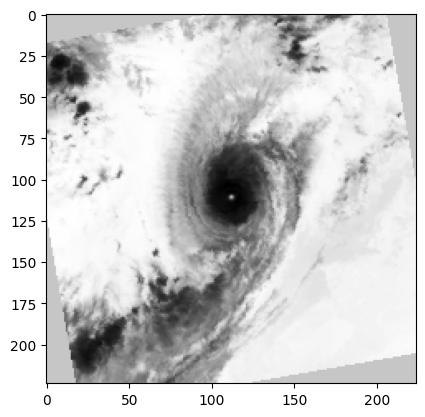

In [48]:
import matplotlib.pyplot as plt

# Loss and optimizer
criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation during validation
    (data, target) = test_set[500]
    # plot the image
    plt.imshow(data, cmap='gray')
    data = torch.Tensor(data)
    data = data.to(device)
    data = torch.reshape(data, [1, 1, data.size()[0], data.size()[1]])
    output = model(data)
    target = torch.Tensor([target], ).to(device)
    output = torch.reshape(output, (1, ))
    loss = criterion(output, target)
    print(f'Correct central pressure: {target[0]}')
    print(f'Predicted central presssure: {output[0]}')
    print(f'RMSE: {loss.item() ** 0.5}')

In [18]:
test_set[1000][0].reshape(1, 224, 224)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

Training resent 50 (model 5) for another 10 epochs (16-25):

In [6]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

# Load a ResNet model
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Modify the model to take single channel images
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=True)

# Modify the model for regressing the wind pressure
num_features_in = model.fc.in_features  # Get the number of input features from the previous layer
model.fc = nn.Linear(in_features=num_features_in, out_features=1)  # New linear layer with 1 output

# load the model trained for 10 epochs:
model.load_state_dict(torch.load('/kaggle/working/model5/model_20240426_052058_14'))

# Freeze pre-trained layers as the dataset is small
for param in model.parameters():
    param.requires_grad = False  # Freeze all parameters

# Unfreeze first layer and last layer
for param in model.conv1.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 141MB/s] 


In [8]:
# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train(model, trainloader):
    running_loss = 0.0
    total_loss = 0.0
    
    model.train()
    
    for batch_num, data in enumerate(trainloader):
        # One batch of the data (64 images and 64 labels) are held in the data variable

        # Data is a tuple, with images in data[0] and labels in data[1]
        images, labels = data

        
        # Move data to device (GPU/CPU)
        images, labels = images.to(device), labels.to(device)  
        
        # cast pixels and labels to float
        images, labels = torch.Tensor(images).float(), torch.Tensor(labels).float()

        # Reshape the image tensor to add a channel dimension (only one channel)
        images = torch.reshape(images, [images.size()[0], 1, images.size()[1], images.size()[2]])
        
        optimizer.zero_grad()

        # Forward pass
        predictions = model(images)
        # Calculate the loss
        predictions = torch.reshape(predictions, labels.shape)
        loss = criterion(predictions, labels)
        # backward pass
        loss.backward()
        # update weights
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        total_loss += loss.item() 
        if batch_num % 50 == 49:    # print every 50 mini-batches
            print(f'From batch {batch_num - 49} to batch {batch_num} | RMSE: {(running_loss / 50) ** 0.5:.3f}')
            running_loss = 0.0
     
    total_loss /= len(trainloader)
    return total_loss

def validate(model, valloader):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation during validation
        for data, target in valloader:
            data, target = data.to(device), target.to(device)  # Move data to device (GPU/CPU)
            data = torch.reshape(data, [data.size()[0], 1, data.size()[1], data.size()[2]])
            output = model(data)
            output = torch.reshape(output, target.shape)
            loss = criterion(output, target)
            total_loss += loss.item()
        return total_loss / len(valloader)

In [8]:
from datetime import datetime
from tqdm import tqdm

# max_epochs = 10
print(f'Running for {10} epochs')

train_losses = np.load('/kaggle/working/model5/train_loss.npy').tolist()
val_losses = np.load('/kaggle/working/model5/val_loss.npy').tolist()

best_vloss = np.min(val_losses)

model_dir = 'model5'

# use GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

for epoch in tqdm(range(15, 25)):
    print('EPOCH {}:'.format(epoch + 1))
    
    train_loss = train(model, trainloader)
    print(f'\nTraining RMSE of epoch {epoch + 1}: {train_loss ** 0.5:.3f}')
    train_losses.append(train_loss)
    
    val_loss = validate(model, valloader)
    print(f'\Validation RMSE of epoch {epoch + 1}: {val_loss ** 0.5:.3f}')
    val_losses.append(val_loss)
    
    if val_loss < best_vloss: # Save the model
        best_vloss = val_loss
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        model_path = os.path.join(model_dir, 'model_{}_{}'.format(timestamp, epoch))
        print(f'Model with current best validation loss saved! Path: {model_path}')
        torch.save(model.state_dict(), model_path)

Running for 10 epochs


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 16:
From batch 0 to batch 49 | RMSE: 15.641
From batch 50 to batch 99 | RMSE: 5.070
From batch 100 to batch 149 | RMSE: 6.093

Training RMSE of epoch 16: 9.658


 10%|█         | 1/10 [12:44<1:54:37, 764.15s/it]

\Validation RMSE of epoch 16: 7.697
EPOCH 17:
From batch 0 to batch 49 | RMSE: 5.230
From batch 50 to batch 99 | RMSE: 4.729
From batch 100 to batch 149 | RMSE: 5.103

Training RMSE of epoch 17: 5.042


 20%|██        | 2/10 [24:58<1:39:30, 746.35s/it]

\Validation RMSE of epoch 17: 8.542
EPOCH 18:
From batch 0 to batch 49 | RMSE: 4.433
From batch 50 to batch 99 | RMSE: 6.965
From batch 100 to batch 149 | RMSE: 4.305

Training RMSE of epoch 18: 5.350


 30%|███       | 3/10 [37:13<1:26:28, 741.21s/it]

\Validation RMSE of epoch 18: 6.551
EPOCH 19:
From batch 0 to batch 49 | RMSE: 5.213
From batch 50 to batch 99 | RMSE: 5.463
From batch 100 to batch 149 | RMSE: 3.793

Training RMSE of epoch 19: 4.744


 40%|████      | 4/10 [49:17<1:13:26, 734.43s/it]

\Validation RMSE of epoch 19: 7.587
EPOCH 20:
From batch 0 to batch 49 | RMSE: 4.666
From batch 50 to batch 99 | RMSE: 4.634
From batch 100 to batch 149 | RMSE: 5.195

Training RMSE of epoch 20: 4.865


 50%|█████     | 5/10 [1:01:07<1:00:27, 725.60s/it]

\Validation RMSE of epoch 20: 6.673
EPOCH 21:
From batch 0 to batch 49 | RMSE: 5.848
From batch 50 to batch 99 | RMSE: 5.323
From batch 100 to batch 149 | RMSE: 4.303

Training RMSE of epoch 21: 4.949


 60%|██████    | 6/10 [1:13:14<48:24, 726.09s/it]  

\Validation RMSE of epoch 21: 7.169
EPOCH 22:
From batch 0 to batch 49 | RMSE: 4.134
From batch 50 to batch 99 | RMSE: 4.308
From batch 100 to batch 149 | RMSE: 4.432

Training RMSE of epoch 22: 4.421


 70%|███████   | 7/10 [1:25:13<36:11, 723.95s/it]

\Validation RMSE of epoch 22: 9.612
EPOCH 23:
From batch 0 to batch 49 | RMSE: 5.658
From batch 50 to batch 99 | RMSE: 4.524
From batch 100 to batch 149 | RMSE: 5.316

Training RMSE of epoch 23: 5.182


 80%|████████  | 8/10 [1:37:18<24:08, 724.29s/it]

\Validation RMSE of epoch 23: 6.340
Model with current best validation loss saved! Path: model5/model_20240505_130448_22
EPOCH 24:
From batch 0 to batch 49 | RMSE: 4.037
From batch 50 to batch 99 | RMSE: 4.980
From batch 100 to batch 149 | RMSE: 6.715

Training RMSE of epoch 24: 5.375


 90%|█████████ | 9/10 [1:49:09<11:59, 719.98s/it]

\Validation RMSE of epoch 24: 6.365
EPOCH 25:
From batch 0 to batch 49 | RMSE: 5.346
From batch 50 to batch 99 | RMSE: 4.276
From batch 100 to batch 149 | RMSE: 5.099

Training RMSE of epoch 25: 5.225


100%|██████████| 10/10 [2:01:22<00:00, 728.25s/it]

\Validation RMSE of epoch 25: 6.386


In [11]:
import numpy as np
train_losses_np = np.array(train_losses)
val_losses_np = np.array(val_losses)
model_dir = 'model5'
np.save(os.path.join(model_dir, 'train_loss.npy'), train_losses_np)
np.save(os.path.join(model_dir, 'val_loss.npy'), val_losses_np)

In [14]:
def create_and_load_model(path_to_state_dict):
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=True)
    num_features_in = model.fc.in_features
    model.fc = nn.Linear(in_features=num_features_in, out_features=1)  
    model.load_state_dict(torch.load(path_to_state_dict))
    return model

model_dir  = '/kaggle/working/model5'
test_losses = {}
for model_name in os.listdir(model_dir):
    if model_name.endswith('npy'):
        continue
    epoch_num = int(model_name.split('_')[-1])
    model_path = os.path.join(model_dir, model_name)
    model = create_and_load_model(model_path)
    model = model.to(device)
    test_losses[epoch_num] = validate(model, testloader)
    print(f'Test RMSE of epoch {epoch_num + 1}: {test_losses[epoch_num] ** 0.5:.3f}')

import numpy as np
max_val = -1
test_losses_np = np.ones(50) * -1
for (k, v) in test_losses.items():
    test_losses_np[k] = v
np.save(os.path.join(model_dir, 'test_loss.npy'), test_losses_np)

Test RMSE of epoch 8: 6.697
Test RMSE of epoch 4: 8.226
Test RMSE of epoch 3: 9.577
Test RMSE of epoch 1: 15.512
Test RMSE of epoch 9: 6.618
Test RMSE of epoch 10: 6.516
Test RMSE of epoch 11: 7.464
Test RMSE of epoch 2: 10.098
Test RMSE of epoch 23: 6.176
Test RMSE of epoch 15: 6.336
Test RMSE of epoch 5: 7.525


Retraining model 6 for 10 more epochs:

In [7]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

# Load a ResNet model
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Modify the model to take single channel images
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=True)

# Modify the model for regressing the wind pressure
num_features_in = model.fc.in_features  # Get the number of input features from the previous layer
model.fc = nn.Linear(in_features=num_features_in, out_features=1)  # New linear layer with 1 output

# load the model trained for 10 epochs:
model.load_state_dict(torch.load('/kaggle/working/model6/model_20240426_032149_14'))

# Freeze pre-trained layers as the dataset is small
for param in model.parameters():
    param.requires_grad = False  # Freeze all parameters

# Unfreeze first layer and last layer
for param in model.conv1.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

In [9]:
from datetime import datetime
from tqdm import tqdm

# max_epochs = 10
print(f'Running for {10} epochs')

train_losses = np.load('/kaggle/input/model-5-loss-history/train_loss.npy').tolist()
val_losses = np.load('/kaggle/input/model-5-loss-history/val_loss.npy').tolist()

best_vloss = np.min(val_losses)

model_dir = 'model6'

# use GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

for epoch in tqdm(range(15, 25)):
    print('EPOCH {}:'.format(epoch + 1))
    
    train_loss = train(model, trainloader)
    print(f'\nTraining RMSE of epoch {epoch + 1}: {train_loss ** 0.5:.3f}')
    train_losses.append(train_loss)
    
    val_loss = validate(model, valloader)
    print(f'\Validation RMSE of epoch {epoch + 1}: {val_loss ** 0.5:.3f}')
    val_losses.append(val_loss)
    
    if val_loss < best_vloss: # Save the model
        best_vloss = val_loss
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        model_path = os.path.join(model_dir, 'model_{}_{}'.format(timestamp, epoch))
        print(f'Model with current best validation loss saved! Path: {model_path}')
        torch.save(model.state_dict(), model_path)

Running for 10 epochs


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 16:
From batch 0 to batch 49 | RMSE: 11.659
From batch 50 to batch 99 | RMSE: 4.736
From batch 100 to batch 149 | RMSE: 6.185

Training RMSE of epoch 16: 7.577


 10%|█         | 1/10 [11:14<1:41:06, 674.08s/it]

\Validation RMSE of epoch 16: 6.098
EPOCH 17:
From batch 0 to batch 49 | RMSE: 4.044
From batch 50 to batch 99 | RMSE: 4.318
From batch 100 to batch 149 | RMSE: 3.722

Training RMSE of epoch 17: 4.245


 20%|██        | 2/10 [22:09<1:28:24, 663.05s/it]

\Validation RMSE of epoch 17: 6.698
EPOCH 18:
From batch 0 to batch 49 | RMSE: 4.863
From batch 50 to batch 99 | RMSE: 5.139
From batch 100 to batch 149 | RMSE: 4.093

Training RMSE of epoch 18: 4.612


 30%|███       | 3/10 [33:24<1:17:58, 668.35s/it]

\Validation RMSE of epoch 18: 6.230
EPOCH 19:
From batch 0 to batch 49 | RMSE: 4.341
From batch 50 to batch 99 | RMSE: 4.124
From batch 100 to batch 149 | RMSE: 3.861

Training RMSE of epoch 19: 4.051


 40%|████      | 4/10 [44:33<1:06:52, 668.74s/it]

\Validation RMSE of epoch 19: 9.284
EPOCH 20:
From batch 0 to batch 49 | RMSE: 4.918
From batch 50 to batch 99 | RMSE: 4.314
From batch 100 to batch 149 | RMSE: 3.204

Training RMSE of epoch 20: 4.231


 50%|█████     | 5/10 [55:20<55:03, 660.76s/it]  

\Validation RMSE of epoch 20: 6.310
EPOCH 21:
From batch 0 to batch 49 | RMSE: 3.367
From batch 50 to batch 99 | RMSE: 4.504
From batch 100 to batch 149 | RMSE: 3.572

Training RMSE of epoch 21: 3.873


 60%|██████    | 6/10 [1:06:40<44:30, 667.59s/it]

\Validation RMSE of epoch 21: 7.948
EPOCH 22:
From batch 50 to batch 99 | RMSE: 5.512
From batch 100 to batch 149 | RMSE: 4.072

Training RMSE of epoch 22: 4.740


 70%|███████   | 7/10 [1:20:21<35:52, 717.62s/it]

\Validation RMSE of epoch 22: 5.820
EPOCH 23:
From batch 0 to batch 49 | RMSE: 4.305
From batch 50 to batch 99 | RMSE: 3.358
From batch 100 to batch 149 | RMSE: 4.185

Training RMSE of epoch 23: 3.941


 80%|████████  | 8/10 [1:30:37<22:50, 685.33s/it]

\Validation RMSE of epoch 23: 5.885
EPOCH 24:
From batch 0 to batch 49 | RMSE: 4.295
From batch 50 to batch 99 | RMSE: 3.066
From batch 100 to batch 149 | RMSE: 3.605

Training RMSE of epoch 24: 3.828


 90%|█████████ | 9/10 [1:41:11<11:09, 669.11s/it]

\Validation RMSE of epoch 24: 5.476
Model with current best validation loss saved! Path: model6/model_20240505_171754_23
EPOCH 25:
From batch 0 to batch 49 | RMSE: 3.722
From batch 50 to batch 99 | RMSE: 3.255
From batch 100 to batch 149 | RMSE: 2.837

Training RMSE of epoch 25: 3.281


100%|██████████| 10/10 [1:51:21<00:00, 668.11s/it]

\Validation RMSE of epoch 25: 6.416


In [13]:
from datetime import datetime
from tqdm import tqdm

# max_epochs = 10
print(f'Running for {10} epochs')

# train_losses = np.load('/kaggle/input/model-5-loss-history/train_loss.npy').tolist()
# val_losses = np.load('/kaggle/input/model-5-loss-history/val_loss.npy').tolist()

# best_vloss = np.min(val_losses)

model_dir = 'model6'

# use GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

for epoch in tqdm(range(25, 35)):
    print('EPOCH {}:'.format(epoch + 1))
    
    train_loss = train(model, trainloader)
    print(f'\nTraining RMSE of epoch {epoch + 1}: {train_loss ** 0.5:.3f}')
    train_losses.append(train_loss)
    
    val_loss = validate(model, valloader)
    print(f'\Validation RMSE of epoch {epoch + 1}: {val_loss ** 0.5:.3f}')
    val_losses.append(val_loss)
    
    if val_loss < best_vloss: # Save the model
        best_vloss = val_loss
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        model_path = os.path.join(model_dir, 'model_{}_{}'.format(timestamp, epoch))
        print(f'Model with current best validation loss saved! Path: {model_path}')
        torch.save(model.state_dict(), model_path)

Running for 10 epochs


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 26:
From batch 0 to batch 49 | RMSE: 3.659
From batch 50 to batch 99 | RMSE: 4.127
From batch 100 to batch 149 | RMSE: 4.251

Training RMSE of epoch 26: 3.822


 10%|█         | 1/10 [10:51<1:37:45, 651.78s/it]

\Validation RMSE of epoch 26: 5.308
Model with current best validation loss saved! Path: model6/model_20240505_174605_25
EPOCH 27:
From batch 0 to batch 49 | RMSE: 3.139
From batch 50 to batch 99 | RMSE: 3.003
From batch 100 to batch 149 | RMSE: 2.760

Training RMSE of epoch 27: 3.123


 20%|██        | 2/10 [20:54<1:23:02, 622.83s/it]

\Validation RMSE of epoch 27: 7.157
EPOCH 28:
From batch 0 to batch 49 | RMSE: 3.285
From batch 50 to batch 99 | RMSE: 3.965
From batch 100 to batch 149 | RMSE: 4.625

Training RMSE of epoch 28: 3.871


 30%|███       | 3/10 [31:22<1:12:58, 625.46s/it]

\Validation RMSE of epoch 28: 5.207
Model with current best validation loss saved! Path: model6/model_20240505_180636_27
EPOCH 29:
From batch 0 to batch 49 | RMSE: 3.547
From batch 50 to batch 99 | RMSE: 3.780
From batch 100 to batch 149 | RMSE: 2.939

Training RMSE of epoch 29: 3.302


 40%|████      | 4/10 [41:26<1:01:40, 616.73s/it]

\Validation RMSE of epoch 29: 5.751
EPOCH 30:
From batch 0 to batch 49 | RMSE: 4.200
From batch 50 to batch 99 | RMSE: 3.720
From batch 100 to batch 149 | RMSE: 3.270

Training RMSE of epoch 30: 3.652


 50%|█████     | 5/10 [51:54<51:44, 620.80s/it]  

\Validation RMSE of epoch 30: 5.210
EPOCH 31:
From batch 0 to batch 49 | RMSE: 3.181
From batch 50 to batch 99 | RMSE: 3.200
From batch 100 to batch 149 | RMSE: 3.485

Training RMSE of epoch 31: 3.331


 60%|██████    | 6/10 [1:02:43<42:01, 630.30s/it]

\Validation RMSE of epoch 31: 7.900
EPOCH 32:
From batch 0 to batch 49 | RMSE: 4.617
From batch 50 to batch 99 | RMSE: 4.164
From batch 100 to batch 149 | RMSE: 4.132

Training RMSE of epoch 32: 4.254


 70%|███████   | 7/10 [1:12:34<30:52, 617.46s/it]

\Validation RMSE of epoch 32: 7.858
EPOCH 33:
From batch 0 to batch 49 | RMSE: 3.135
From batch 50 to batch 99 | RMSE: 2.830
From batch 100 to batch 149 | RMSE: 2.922

Training RMSE of epoch 33: 3.112


 80%|████████  | 8/10 [1:22:45<20:31, 615.61s/it]

\Validation RMSE of epoch 33: 5.382
EPOCH 34:
From batch 0 to batch 49 | RMSE: 5.027
From batch 50 to batch 99 | RMSE: 3.765
From batch 100 to batch 149 | RMSE: 3.846

Training RMSE of epoch 34: 4.405


 90%|█████████ | 9/10 [1:32:36<10:07, 607.71s/it]

\Validation RMSE of epoch 34: 5.520
EPOCH 35:
From batch 0 to batch 49 | RMSE: 3.503
From batch 50 to batch 99 | RMSE: 3.389
From batch 100 to batch 149 | RMSE: 3.218

Training RMSE of epoch 35: 3.274


100%|██████████| 10/10 [1:43:48<00:00, 622.85s/it]

\Validation RMSE of epoch 35: 5.254


In [14]:
import numpy as np
train_losses_np = np.array(train_losses)
val_losses_np = np.array(val_losses)
model_dir = 'model6'
np.save(os.path.join(model_dir, 'train_loss.npy'), train_losses_np)
np.save(os.path.join(model_dir, 'val_loss.npy'), val_losses_np)

In [15]:
def create_and_load_model(path_to_state_dict):
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=True)
    num_features_in = model.fc.in_features
    model.fc = nn.Linear(in_features=num_features_in, out_features=1)  
    model.load_state_dict(torch.load(path_to_state_dict))
    return model

model_dir  = '/kaggle/working/model6'
test_losses = {}
for model_name in os.listdir(model_dir):
    if model_name.endswith('npy'):
        continue
    epoch_num = int(model_name.split('_')[-1])
    model_path = os.path.join(model_dir, model_name)
    model = create_and_load_model(model_path)
    model = model.to(device)
    test_losses[epoch_num] = validate(model, testloader)
    print(f'Test RMSE of epoch {epoch_num + 1}: {test_losses[epoch_num] ** 0.5:.3f}')

import numpy as np
max_val = -1
test_losses_np = np.ones(50) * -1
for (k, v) in test_losses.items():
    test_losses_np[k] = v
np.save(os.path.join(model_dir, 'test_loss.npy'), test_losses_np)

Test RMSE of epoch 9: 5.935
Test RMSE of epoch 2: 9.405
Test RMSE of epoch 8: 6.065
Test RMSE of epoch 16: 5.597
Test RMSE of epoch 4: 7.172
Test RMSE of epoch 26: 5.160
Test RMSE of epoch 15: 5.667
Test RMSE of epoch 1: 13.986
Test RMSE of epoch 24: 5.381
Test RMSE of epoch 14: 5.783
Test RMSE of epoch 28: 5.085


In [22]:
!rm -f pressure-models.zip

In [23]:
import shutil
shutil.make_archive('pressure-models', 'zip', '/kaggle/working')

'/kaggle/working/pressure-models.zip'

Training models for grade classification:

Using weighted random sampler to solve the problem of class imbalance:

In [42]:
import numpy as np
import torch
import torchvision.transforms.v2.functional as transforms
from torch.utils.data import DataLoader
from pyphoon2.DigitalTyphoonDataset import DigitalTyphoonDataset


# Hyperparameters
num_epochs = 50
batch_size = 128
learning_rate = 0.01
standardize_range = (150, 350)
downsample_size = (224, 224)

# filtering function
def image_filter(image):
    return image.grade() < 7


# preprocessing function:
def transform_func(image_ray):
    # Clip the pixel values between 150 and 350
    image_ray = np.clip(image_ray, standardize_range[0], standardize_range[1])

    image_ray = torch.Tensor(image_ray)
    image_ray = torch.reshape(image_ray, [1, 1, image_ray.size()[0], image_ray.size()[1]])

    # Apply z-score normalization
    image_ray = transforms.normalize(image_ray, [image_ray.mean()], [image_ray.std()])

    # Downsample the images 
    if downsample_size != (512, 512):
        image_ray = transforms.resize(image_ray, size=downsample_size, antialias=True)

    # augmentation

    # random horizontal flip
    image_ray = transforms.horizontal_flip(image_ray)
    # random vertical flip
    image_ray = transforms.vertical_flip(image_ray)
    # random rotation
    image_ray = transforms.rotate(image_ray, angle=10)

    image_ray = torch.reshape(image_ray, [image_ray.size()[2], image_ray.size()[3]])
    return image_ray.numpy()



dataset = DigitalTyphoonDataset(
    str(images_path),
    str(metadata_path),
    str(json_path),
    'grade', # retreive pressure label from the dataset
    filter_func=image_filter, # filter out grade 7 cyclones
    transform_func=transform_func,  # the transform function defined above)
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


seed = 42
generator = torch.Generator().manual_seed(seed)
train_set, val_set, test_set = dataset.random_split([0.7, 0.1, 0.2], split_by='image', generator=generator)

print(f'No. of cyclones: {dataset.get_number_of_sequences()}')
print(f'Total number of images: {len(dataset)}')
print(f'Number of images in train set: {len(train_set)}')
print(f'Number of images in validation set: {len(val_set)}')
print(f'Number of images in test set: {len(test_set)}')

No. of cyclones: 181
Total number of images: 33609
Number of images in train set: 23527
Number of images in validation set: 3361
Number of images in test set: 6721


In [49]:
a = {2: 0, 3: 0, 4:0, 5:0, 6:0}
b = {2: 0, 3: 0, 4:0, 5:0, 6:0}
c = {2: 0, 3: 0, 4:0, 5:0, 6:0}
for (_, grade) in train_set:
    a[grade] += 1
for (_, grade) in val_set:
    b[grade] += 1
for (_, grade) in test_set:
    c[grade] += 1

In [50]:
a, b, c

({2: 6837, 3: 6034, 4: 2764, 5: 4795, 6: 3097},
 {2: 927, 3: 849, 4: 423, 5: 724, 6: 438},
 {2: 1994, 3: 1664, 4: 773, 5: 1416, 6: 874})

In [72]:
total_images = sum(a.values())
weights = [total_images / a[grade] for (_, grade) in train_set]
weights = torch.tensor(weights, dtype=torch.double)
len(weights)

23527

In [73]:
torch.save({'sampling_weights': weights}, 'sampling_weights')

In [74]:
from torch.utils.data import WeightedRandomSampler
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

In [75]:
trainloader = DataLoader(train_set, batch_size=batch_size, sampler=sampler)
valloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [76]:
a = {2: 0, 3: 0, 4:0, 5:0, 6:0}
for (_, grades) in trainloader:
    for grade in grades:
        a[grade.item()] += 1
a

{2: 4689, 3: 4675, 4: 4668, 5: 4805, 6: 4690}

In [77]:
sum(a.values())

23527

In [5]:
import numpy as np
import torch
import torchvision.transforms.v2.functional as transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from pyphoon2.DigitalTyphoonDataset import DigitalTyphoonDataset


# Hyperparameters
num_epochs = 50
batch_size = 128
learning_rate = 0.01
standardize_range = (150, 350)
downsample_size = (224, 224)

# filtering function
def image_filter(image):
    return image.grade() < 7


# preprocessing function:
def transform_func(image_ray):
    # Clip the pixel values between 150 and 350
    image_ray = np.clip(image_ray, standardize_range[0], standardize_range[1])

    image_ray = torch.Tensor(image_ray)
    image_ray = torch.reshape(image_ray, [1, 1, image_ray.size()[0], image_ray.size()[1]])

    # Apply z-score normalization
    image_ray = transforms.normalize(image_ray, [image_ray.mean()], [image_ray.std()])

    # Downsample the images 
    if downsample_size != (512, 512):
        image_ray = transforms.resize(image_ray, size=downsample_size, antialias=True)

    # augmentation

    # random horizontal flip
    image_ray = transforms.horizontal_flip(image_ray)
    # random vertical flip
    image_ray = transforms.vertical_flip(image_ray)
    # random rotation
    image_ray = transforms.rotate(image_ray, angle=10)

    image_ray = torch.reshape(image_ray, [image_ray.size()[2], image_ray.size()[3]])
    return image_ray.numpy()



dataset = DigitalTyphoonDataset(
    str(images_path),
    str(metadata_path),
    str(json_path),
    'grade', # retreive pressure label from the dataset
    filter_func=image_filter, # filter out grade 7 cyclones
    transform_func=transform_func,  # the transform function defined above)
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


seed = 42
generator = torch.Generator().manual_seed(seed)
train_set, val_set, test_set = dataset.random_split([0.7, 0.1, 0.2], split_by='image', generator=generator)

print(f'No. of cyclones: {dataset.get_number_of_sequences()}')
print(f'Total number of images: {len(dataset)}')
print(f'Number of images in train set: {len(train_set)}')
print(f'Number of images in validation set: {len(val_set)}')
print(f'Number of images in test set: {len(test_set)}')

weights = torch.load('/kaggle/working/sampling_weights')['sampling_weights']
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

trainloader = DataLoader(train_set, batch_size=batch_size, sampler=sampler)
valloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

No. of cyclones: 181
Total number of images: 33609
Number of images in train set: 23527
Number of images in validation set: 3361
Number of images in test set: 6721


Model 1 - resnet 18:

In [6]:
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

# Load a ResNet model
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Freeze pre-trained layers as the dataset is small
for param in model.parameters():
    param.requires_grad = False  # Freeze all parameters

# Modify the model to take single channel images
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=True)

# Modify the model for regressing the wind pressure
num_features_in = model.fc.in_features  # Get the number of input features from the previous layer
model.fc = nn.Linear(in_features=num_features_in, out_features=5)  # New linear layer with 1 output

# Unfreeze first layer and last layer
for param in model.conv1.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 140MB/s] 


In [7]:
from torchsummary import summary
model = model.to(device)
summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,200
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [7]:
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
from torchmetrics import Accuracy

def train(model, trainloader):
    epoch_acc = Accuracy(task='multiclass', num_classes=5).to(device)
    batch_acc = Accuracy(task='multiclass', num_classes=5).to(device)
    total_loss = 0
    model.train()
    
    for batch_num, data in enumerate(trainloader):
        # One batch of the data (64 images and 64 labels) are held in the data variable

        # Data is a tuple, with images in data[0] and labels in data[1]
        images, labels = data
        labels = labels.type(torch.LongTensor)
        labels -= 2 # labels are 2-6
        
        # Move data to device (GPU/CPU)
        images, labels = images.to(device), labels.to(device)  
        
        # cast pixels to float
        images = torch.Tensor(images).float()

        # Reshape the image tensor to add a channel dimension (only one channel)
        images = torch.reshape(images, [images.size()[0], 1, images.size()[1], images.size()[2]])
        
        optimizer.zero_grad()

        # Forward pass
        predictions = model(images)
        # Calculate the loss
#         predictions = torch.reshape(predictions, labels.shape)
        loss = criterion(predictions, labels)
        # backward pass
        loss.backward()
        # update weights
        optimizer.step()
        
        # print statistics
        total_loss += loss.item()
        epoch_acc.update(predictions, labels)
        batch_acc.update(predictions, labels)
        if batch_num % 50 == 49:    # print every 50 mini-batches
            print(f'From batch {batch_num - 49} to batch {batch_num} | Accuracy: {batch_acc.compute() * 100:.3f}%')
            running_loss = 0.0
            batch_acc.reset()
    return (epoch_acc.compute(), total_loss / len(trainloader))

def validate(model, valloader):
    model.eval()  # Set model to evaluation mode
    acc = Accuracy(task='multiclass', num_classes=5).to(device)
    total_loss = 0
    with torch.no_grad():  # Disable gradient calculation during validation
        for data, target in valloader:
            target = target.type(torch.LongTensor)
            target -= 2
            data, target = data.to(device), target.to(device)  # Move data to device (GPU/CPU)
            data = torch.reshape(data, [data.size()[0], 1, data.size()[1], data.size()[2]])
            output = model(data)
#             output = torch.reshape(output, target.shape)
            loss = criterion(output, target)
            total_loss += loss.item()
            acc.update(output, target)
        return (acc.compute(), total_loss / len(valloader))

In [ ]:
from datetime import datetime
from tqdm import tqdm

max_epochs = 15
print(f'Running for {max_epochs} epochs')

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_vloss = 1_000_000.
best_vacc = -1

model_dir = 'model1'
os.makedirs(model_dir, exist_ok=True)

# use GPU
model = model.to(device)

for epoch in tqdm(range(max_epochs)):
    print('EPOCH {}:'.format(epoch + 1))
    
    (train_acc, train_loss) = train(model, trainloader)
    print(f'\nTraining loss of epoch {epoch + 1}: {train_loss:.3f}, accuracy: {train_acc * 100:.3f}%')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    (val_acc, val_loss) = validate(model, valloader)
    print(f'\Validation loss of epoch {epoch + 1}: {val_loss:.3f}, accuracy: {val_acc * 100:.3f}%')
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    if val_loss < best_vloss or val_acc > best_vacc: # Save the model
        best_vloss = min(val_loss, best_vloss)
        best_vacc = max(val_acc, best_vacc)
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        model_path = os.path.join(model_dir, 'model_{}_{}'.format(timestamp, epoch))
        print(f'Model saved! Path: {model_path}')
        model_state = {'optimizer': optimizer.state_dict(), 'model': model.state_dict()} 
        torch.save(model_state, model_path)

Running for 15 epochs


  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH 1:
From batch 0 to batch 49 | Accuracy: 77.719%
From batch 50 to batch 99 | Accuracy: 81.406%
From batch 100 to batch 149 | Accuracy: 85.062%

Training loss of epoch 1: 0.453, accuracy: 82.229%


  7%|▋         | 1/15 [10:37<2:28:47, 637.65s/it]

\Validation loss of epoch 1: 0.714, accuracy: 74.650%
Model saved! Path: model1/model_20240508_110300_0
EPOCH 2:
From batch 0 to batch 49 | Accuracy: 88.344%
From batch 50 to batch 99 | Accuracy: 90.078%
From batch 100 to batch 149 | Accuracy: 91.859%

Training loss of epoch 2: 0.255, accuracy: 90.500%


 13%|█▎        | 2/15 [21:06<2:17:05, 632.70s/it]

\Validation loss of epoch 2: 0.483, accuracy: 82.327%
Model saved! Path: model1/model_20240508_111329_1
EPOCH 3:
From batch 0 to batch 49 | Accuracy: 93.625%
From batch 50 to batch 99 | Accuracy: 94.422%
From batch 100 to batch 149 | Accuracy: 95.000%

Training loss of epoch 3: 0.156, accuracy: 94.402%


 20%|██        | 3/15 [31:33<2:05:57, 629.79s/it]

\Validation loss of epoch 3: 0.450, accuracy: 84.796%
Model saved! Path: model1/model_20240508_112355_2
EPOCH 4:
From batch 0 to batch 49 | Accuracy: 95.203%
From batch 50 to batch 99 | Accuracy: 96.250%
From batch 100 to batch 149 | Accuracy: 96.234%

Training loss of epoch 4: 0.116, accuracy: 96.056%


 27%|██▋       | 4/15 [42:00<1:55:18, 628.98s/it]

\Validation loss of epoch 4: 0.595, accuracy: 82.803%
EPOCH 5:
From batch 0 to batch 49 | Accuracy: 97.453%
From batch 50 to batch 99 | Accuracy: 97.219%
From batch 100 to batch 149 | Accuracy: 97.812%

Training loss of epoch 5: 0.078, accuracy: 97.479%


 33%|███▎      | 5/15 [52:16<1:44:01, 624.14s/it]

\Validation loss of epoch 5: 0.461, accuracy: 85.867%
Model saved! Path: model1/model_20240508_114439_4
EPOCH 6:
From batch 0 to batch 49 | Accuracy: 97.141%
From batch 50 to batch 99 | Accuracy: 97.484%


In [42]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [41]:
del testloader